In [183]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from warnings import filterwarnings
filterwarnings('ignore')
%matplotlib inline

train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

train_X, val_X, train_y, val_y = train_test_split(train.iloc[:,1:], train.label, 
                                                    test_size=0.2, random_state = 42)
train_X = train_X/255.0
val_X = val_X/255.0

 # Check autehntication of dataset

Text(0.5, 1.0, '6')

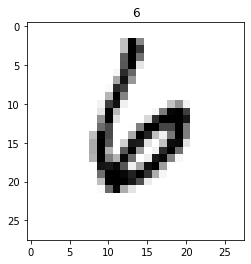

In [185]:
plt.imshow(np.array(train_X.loc[34941]).reshape(28,28), cmap = plt.cm.binary)
plt.title(train_y.loc[34941])

In [71]:
#no.of hidden units
n_classes = 10
input_features = train_X.shape[1]
learning_rate = 0.001

In [72]:
def convert(df):
    try:
        df = np.array(df, dtype='float32').reshape([-1, df.shape[1]])
    except:
        df = np.array(df)
        print('error')
    return df

train_X, val_X = convert(train_X), convert(val_X)
train_y, val_y = convert(train_y), convert(val_y)
test_X = convert(test/255)

error
error


In [73]:
# Use tf.data API to shuffle and batch data.
batch_size = 256
train_data = tf.data.Dataset.from_tensor_slices((train_X, train_y))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

# Storing Weights and  Biases

In [97]:
# random weights initialiser
random = tf.initializers.RandomNormal()
weight = {
            'c1': tf.Variable(random([3,3,1,32]), dtype='float32'),
            'c2': tf.Variable(random([3,3,32,32]), dtype='float32'),
            'c3': tf.Variable(random([5,5,32,32]), dtype='float32'),
    
            'c4': tf.Variable(random([3,3,32,64]), dtype='float32'),
            'c5': tf.Variable(random([3,3,64,64]), dtype='float32'),
            'c6': tf.Variable(random([5,5,64,64]), dtype='float32'),
    
    
            'fc1': tf.Variable(random([4*4*64, 128]), dtype='float32'),
            'out': tf.Variable(random([128, n_classes]), dtype='float32')
          }

bias = {
            'c1': tf.Variable(tf.zeros([32]), dtype='float32'),
            'c2': tf.Variable(tf.zeros([32]), dtype='float32'),
            'c3': tf.Variable(tf.zeros([32]), dtype='float32'),
    
            'c4': tf.Variable(tf.zeros([64]), dtype='float32'),
            'c5': tf.Variable(tf.zeros([64]), dtype='float32'),
            'c6': tf.Variable(tf.zeros([64]), dtype='float32'),
    
            'fc1': tf.Variable(tf.zeros([128]), dtype='float32'),
            'out': tf.Variable(tf.zeros([n_classes]), dtype='float32')
       }

# Function Wrappers

In [98]:
def conv2d(x, W, b, strides, padding):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding=padding)
    #print(np.mean(x), np.var(x))
    #x = tf.nn.batch_normalization(x, mean=np.mean(x), variance=np.mean(x),
     #                                 offset=None, scale=None, variance_epsilon=10**-8)
    x = tf.nn.bias_add(x,b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')
def dropout(x, rate):
    return tf.nn.dropout(x, rate=rate)

# Forward Propogation

In [76]:
def conv_forward_prop(x):
    #grayscale
    x = tf.reshape(x, [-1, 28, 28, 1])

    #conv. layers
    conv_layer_1 = conv2d(x, weight['c1'], bias['c1'], strides=1, padding='VALID' )
    conv_layer_2 = conv2d(conv_layer_1, weight['c2'], bias['c2'], strides=1, padding='VALID' )
    conv_layer_3 = conv2d(conv_layer_2, weight['c3'], bias['c3'], strides=2, padding='SAME' )
    conv_layer_3 = dropout(conv_layer_3, rate=0.2 )
    
    
    conv_layer_4 = conv2d(conv_layer_3, weight['c4'], bias['c4'], strides=1, padding='VALID' )
    conv_layer_5 = conv2d(conv_layer_4, weight['c5'], bias['c5'], strides=1, padding='VALID' )
    conv_layer_6 = conv2d(conv_layer_5, weight['c6'], bias['c6'], strides=2, padding='SAME' )
    conv_layer_6 = dropout(conv_layer_6, rate=0.2 )
    
    #flattening
    fc_layer = tf.reshape(conv_layer_6, [-1, weight['fc1'].shape[0]] )
    
    fc_layer = tf.add(tf.matmul(fc_layer,  weight['fc1']), bias['fc1'] )
    fc_layer = tf.nn.relu(fc_layer)
    #fc_layer = tf.nn.batch_normalization(fc_layer)
    fc_layer = tf.nn.dropout(fc_layer, rate=0.2)
    
    layer_out = tf.add(tf.matmul(fc_layer, weight['out']), bias['out'] )
    return tf.nn.softmax(layer_out)

# Loss Function

In [77]:
# Cross-Entropy loss function.
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=n_classes)
    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    # Compute cross-entropy.
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)


# Back Prop

In [91]:
optimizer = tf.optimizers.Adam(learning_rate)

def optimize(x, y): 
    with tf.GradientTape() as tape:
        pred = conv_forward_prop(x)
        loss = cross_entropy(pred, y)
        
    to_train = list(weight.values()) + list(bias.values())
    gradients = tape.gradient(loss, to_train)
        
    optimizer.apply_gradients(zip(gradients, to_train))

In [174]:
training_steps = 200
display_step = 10
# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    optimize(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = conv_forward_prop(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 10, loss: 17.470636, accuracy: 0.984375
step: 20, loss: 15.628522, accuracy: 0.976562
step: 30, loss: 15.112423, accuracy: 0.972656
step: 40, loss: 16.624254, accuracy: 0.976562
step: 50, loss: 9.620112, accuracy: 0.984375
step: 60, loss: 15.486656, accuracy: 0.984375
step: 70, loss: 9.777613, accuracy: 0.984375
step: 80, loss: 15.904358, accuracy: 0.972656
step: 90, loss: 13.396223, accuracy: 0.980469
step: 100, loss: 7.127341, accuracy: 0.996094
step: 110, loss: 8.630663, accuracy: 0.984375
step: 120, loss: 9.391678, accuracy: 0.992188
step: 130, loss: 10.677591, accuracy: 0.988281
step: 140, loss: 9.551406, accuracy: 0.992188
step: 150, loss: 9.440463, accuracy: 0.988281
step: 160, loss: 8.684832, accuracy: 0.992188
step: 170, loss: 4.888620, accuracy: 0.996094
step: 180, loss: 23.031889, accuracy: 0.960938
step: 190, loss: 6.654606, accuracy: 0.988281
step: 200, loss: 20.052725, accuracy: 0.976562


In [175]:
# Test model on validation set.
pred = conv_forward_prop(val_X[100])
print("Test Accuracy: %f" % accuracy(pred, val_y[100]))

Test Accuracy: 1.000000


# Submission

In [177]:
count = {}
for i in range(15):
    count[i] = 2001*i

for key,value in count.items():
    if key != 14:
        predictions = conv_forward_prop(test_X[count[key]:count[key+1]])
        holdout[key] = tf.argmax(predictions, axis=1).numpy()

In [178]:
final=[]
for i in range (14):
    x = list(holdout[i])
    final = final + x
    x = []
    
len(final)

28000

In [179]:
pred_dict = {'ImageId': range(1,28001), 'Label': final}
pred_df = pd.DataFrame(pred_dict)
pred_df.to_csv('Submission2.csv', index=False )

# PREVIEW PREDICTIONS

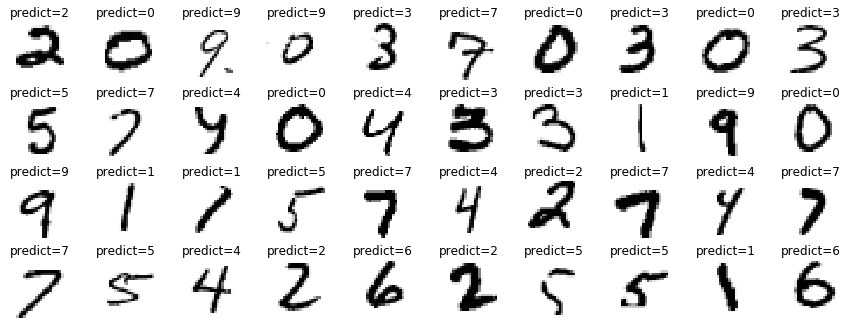

In [182]:
plt.figure(figsize=(15,6))
for i in range(40):  
    plt.subplot(4, 10, i+1)
    plt.imshow(test_X[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.title("predict=%d" % final[i],y=0.9)
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()
